In [1]:
import findspark
findspark.init()

In [2]:
# configuration, worked on using python@3.10.9 
import os
import urllib
import json
from threading import Thread, Lock
from tqdm import tqdm
import pyspark
import pandas as pd
from pyspark import SQLContext
from pyspark.sql.functions import *

In [3]:
conf = pyspark.SparkConf()

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)
spark.conf.set("spark.sql.shuffle.partitions", "5")
spark

In [5]:
file_location = "result.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

DataFrame[id: string, line: string, stop_name: string, borough: string, lat: double, long: double, n_label: string, s_label: string, entries: double, exits: double, arrests: int, complaints: int, summons: int]

In [6]:
df = df.withColumn('borough', when(df.borough == 'M', 'Manhattan')
                          .when(df.borough == 'Bk', 'Brooklyn')
                          .when(df.borough == 'Bx', 'Bronx')
                          .when(df.borough == 'Q', 'Queens')
                          .when(df.borough == 'SI', 'Staten Island')
                          .otherwise(df.borough))
df.toPandas()

,id,line,stop_name,borough,lat,long,n_label,s_label,entries,exits,arrests,complaints,summons
0,F12,Queens Blvd,5 Av/53 St,Manhattan,40.760167,-73.975224,Queens,Downtown & Brooklyn,1.715401e+11,1.839895e+11,1811,3603,1056
1,637,Lexington Av,Bleecker St,Manhattan,40.725915,-73.994659,Uptown & The Bronx,Downtown,1.965652e+11,1.534667e+11,3444,5079,1046
2,603,Pelham,Middletown Rd,Bronx,40.843863,-73.836322,Pelham Bay Park,Manhattan,1.602757e+10,9.955782e+09,442,1094,842
3,725,Flushing,Times Sq-42 St,Manhattan,40.755477,-73.987691,Queens,34 St - Hudson Yards,4.943579e+11,1.840059e+11,11199,12406,14342
4,606,Pelham,Zerega Av,Bronx,40.836488,-73.847036,Pelham Bay Park,Manhattan,9.471628e+09,5.313407e+09,649,1661,996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,R22,Broadway - Brighton,Prince St,Manhattan,40.724329,-73.997702,Uptown & Queens,Downtown & Brooklyn,1.001154e+11,6.547147e+10,7198,9826,1712
443,J15,Jamaica,Woodhaven Blvd,Queens,40.693879,-73.851576,Jamaica,Manhattan,7.133194e+10,2.695806e+10,843,1287,832
444,D32,Broadway - Brighton,Avenue H,Brooklyn,40.629270,-73.961639,Manhattan,Brighton Beach & Coney Island,1.206304e+10,1.096028e+10,424,814,401
445,F23,6th Av - Culver,4 Av-9 St,Brooklyn,40.670272,-73.989779,Manhattan - Queens,Church Av - Coney Island,5.257801e+11,6.405787e+11,953,1068,597


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime
import folium
from pyspark.sql.window import Window

### Number of complaints per Borough

In [8]:

count_complaints_borough = df.groupBy('borough')\
    .agg(sum('complaints').alias('total_complaints'))\
    .orderBy('total_complaints', ascending=False)



count_complaints_borough = count_complaints_borough.withColumn('borough', when(df.borough == 'M', 'Manhattan')
                          .when(df.borough == 'Bk', 'Brooklyn')
                          .when(df.borough == 'Bx', 'Bronx')
                          .when(df.borough == 'Q', 'Queens')
                          .when(df.borough == 'SI', 'Staten Island')
                          .otherwise(df.borough))


In [9]:
# convert to pandas df
borough_pddf = pd.DataFrame(count_complaints_borough.rdd.map(lambda x: x.asDict()).collect()).dropna().sort_values(by='total_complaints', ascending=False)



<Axes: title={'center': 'Number of complaints per Borough'}, xlabel='borough', ylabel='Number of complaints'>

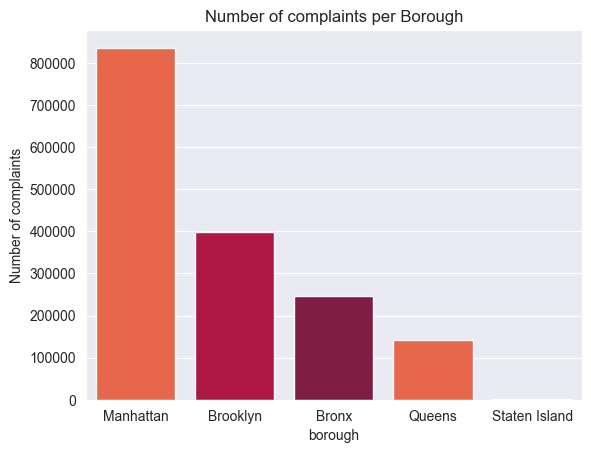

In [10]:
# plotting total number of crimes per borough
sns.set_style('darkgrid')
custom_palette = sns.color_palette(['#FF5733', '#C70039', '#900C3F'])
g=sns.barplot(x='borough',y='total_complaints',data=borough_pddf,palette=custom_palette);
plt.ylabel('Number of complaints');
plt.title("Number of complaints per Borough");
display(g)

### TOP 10 busiest stations in each Borough

In [11]:

from pyspark.sql.functions import rank
# Aggregate the data by borough and station, summing the entries for each station.
station_entries = df.groupBy(['borough', 'stop_name', 'lat', 'long']).agg(sum('entries').alias('total_entries'))

# Rank the stations in each borough based on their entries and select the top 10.
window = Window.partitionBy('borough').orderBy(station_entries['total_entries'].desc())
station_entries = station_entries.withColumn('rank', rank().over(window))
top_stations = station_entries.filter(station_entries['rank'] <= 10)

# Create a map and add circle markers for each station.
borough_colors = {'Manhattan': 'blue', 'Brooklyn': 'green', 'Bronx': 'red', 'Queens': 'purple', 'Staten Island': 'orange'}
m = folium.Map(location=[40.730610, -73.935242], zoom_start=11, tiles="CartoDB dark_matter")

for row in top_stations.collect():
    color = borough_colors[row['borough']]
    rank = row['rank']
    stop_name = row['stop_name']
    popup_text = f"Rank: {rank}<br>Stop Name: {stop_name}"
    folium.CircleMarker(location=[row['lat'], row['long']], radius=5,
                        fill=True, fill_color=color, fill_opacity=0.7, color=color, popup=popup_text).add_to(m)


m


In [12]:
# Load the boroughs shapefile
borough_geo =  gpd.read_file("Borough Boundaries.geojson")


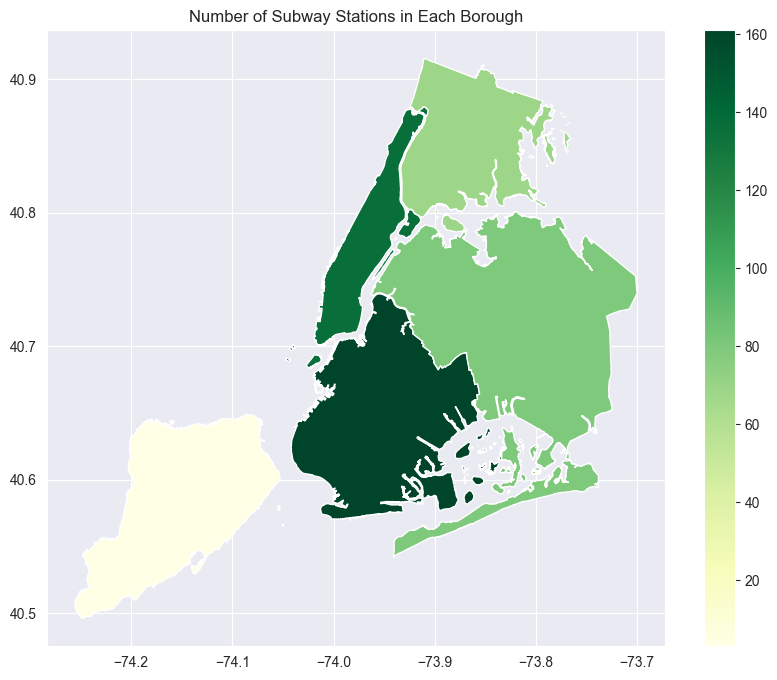

In [13]:
# Load the data into a pandas dataframe
borough_counts = df.groupBy('borough').count().toPandas()
# Merge the data with the borough shapefile
borough_data = borough_geo.merge(borough_counts, left_on='boro_name', right_on='borough')
 

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
borough_data.plot(column='count', cmap='YlGn', ax=ax, legend=True)
ax.set_title("Number of Subway Stations in Each Borough")
plt.show()



In [14]:
display(borough_counts)

,borough,count
0,Bronx,68
1,Queens,79
2,Brooklyn,161
3,Manhattan,136
4,Staten Island,3


# Map of Number of Arrests per Borough

In [15]:

count_arrest_borough = df.groupBy('borough')\
    .agg(sum('arrests').alias('total_arrest'))\
    .orderBy('total_arrest', ascending=False)


In [16]:
# convert to pandas df
borough_pddfa = pd.DataFrame(count_arrest_borough.rdd.map(lambda x: x.asDict()).collect()).dropna().sort_values(by='total_arrest')



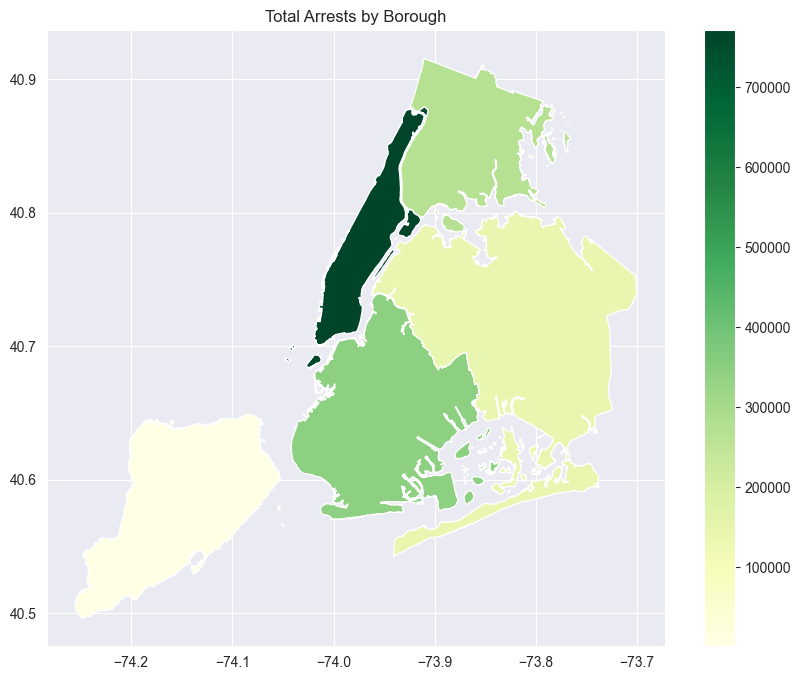

In [17]:

# Merge the data with the borough shapefile
borough_data = borough_geo.merge(borough_pddfa, left_on='boro_name', right_on='borough')
 

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
borough_data.plot(column='total_arrest', cmap='YlGn', ax=ax, legend=True)
ax.set_title("Total Arrests by Borough")
plt.show()


In [18]:
display(borough_pddfa)

,borough,total_arrest
4,Staten Island,1174
3,Queens,144411
2,Bronx,269593
1,Brooklyn,344709
0,Manhattan,771200
